In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLarsCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.decomposition import PCA
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

In [2]:
fires = utils.wrangle()

In [3]:
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,6,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,3,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,7,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Least Squares Regression Analysis

In [16]:
from statsmodels.formula.api import ols

In [18]:
fires['log'] = np.log(fires.area+1)
m = ols('log ~ temp + rain + RH + wind',fires).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                    log   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.345
Date:                Sun, 12 Mar 2017   Prob (F-statistic):              0.252
Time:                        16:20:51   Log-Likelihood:                -903.77
No. Observations:                 517   AIC:                             1818.
Df Residuals:                     512   BIC:                             1839.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7420      0.443      1.674      0.0

# PCA

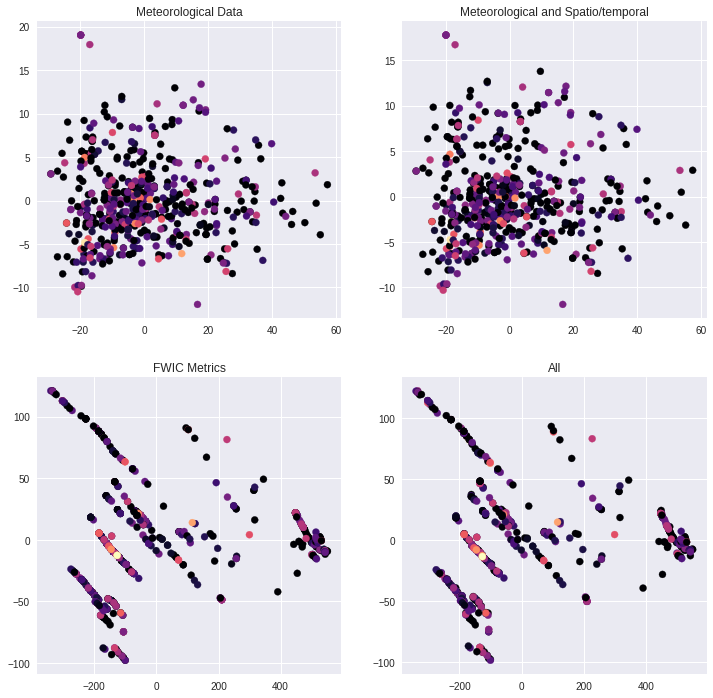

In [53]:
# Here we can see how fire size is distributed across the two dimensions of greatest 
# variation with different subsets of features. 

X1 = fires.ix[:,[8,9, 10, 11]].copy()
X2 = fires.ix[:,[4, 5, 6, 7]].copy()
X3 = fires.ix[:,1:12]
X5 = fires.ix[:,[0,1,2,3, 8, 9, 10, 11]].copy()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

pca1 = PCA(n_components=2).fit_transform(X1)
ax1.scatter(pca1[:,0], pca1[:,1], c=fires.log, cmap=plt.cm.magma)
ax1.set_title("Meteorological Data")


pca5 = PCA(n_components=2).fit_transform(X5)
ax2.scatter(pca5[:,0], pca5[:,1], c=fires.log, cmap=plt.cm.magma)
ax2.set_title("Meteorological and Spatio/temporal")


pca2 = PCA(n_components=2).fit_transform(X2)
ax3.scatter(pca2[:,0], pca2[:,1], c=fires.log, cmap=plt.cm.magma)
ax3.set_title("FWIC Metrics")


pca3 = PCA(n_components=2).fit_transform(X3)
ax4.scatter(pca3[:,0], pca3[:,1], c=fires.log, cmap=plt.cm.magma)
ax4.set_title("All")

f.subplots_adjust(hspace=.2)

plt.show()



# Features

In [54]:
# Determine features 
features = fires.ix[:,[8,9,10,11]]

#Scale input
#ss_X = SS().fit(features)
#X = ss_X.transform(features)
X = scale(features)

#Take log of area and set y
y = np.log(fires.area.values+1).flatten()

In [55]:
# Unscale and evaluate MAE
def eval(y, y_):
    y1 = np.exp(y)-1
    y2 = np.exp(y_)-1
    score = np.mean(np.abs(y1-y2))
    return score

In [56]:
# Train/Test split 75/25
Xtr, Xte, ytr, yte = train_test_split(X, y)
ytr = ytr.flatten()
split_data = (Xtr, Xte, ytr, yte)

# Additional Regression Techniques

## Ridge Regression

In [57]:
def RR(data):
    a = [1, 10, 100, 1000, 10000, 100000]
    ridge = RidgeCV(alphas=a)
    ridge = ridge.fit(data[0], data[2])
    y_ = ridge.predict(data[1])
    return eval(y_, data[3])

## ElasticNet 

In [58]:
def EN(data):
    l1s = [.0001,.001,.01,.1, .5, .7, .9, .95, .99, 1]
    a = [.1, 1, 10, 100, 1000]
    en = ElasticNetCV(l1_ratio=l1s, alphas=a)
    en = en.fit(data[0],data[2])
    y_ = en.predict(data[1])
    return eval(y_, data[3])

## Lasso Lars

In [59]:
def LL(data):
    ll = LassoLarsCV()
    l1 = ll.fit(data[0], data[2])
    y_ = ll.predict(data[1])
    return eval(y_, data[3])

## SVR

### Linear

In [61]:
def SVR_lin(data, param=None):
    # 5 fold CV
    if param==None:
        chosen_cs=[]
        for tr, te in KFold(n_splits=5,shuffle=True).split(data[0]):
            c_cv = [None, np.inf]
            #test all cs for specific fold
            for c in [0.001,0.01, 0.1, 1, 10, 100]:
                svr = SVR(kernel='linear', C=c)
                svr = svr.fit(data[0][tr], data[2][tr])
                y_ = svr.predict(data[0][te])
                score = eval(y_, data[2][te])
                if score < c_cv[1]:
                    c_cv[1] = score
                    c_cv[0] = c
            chosen_cs.append(c_cv[0])
        
        best_c = np.mean(chosen_cs)
    else:
        best_c = param
    
    #run linear SVR with best c
    svr = SVR(kernel='linear', C=best_c)
    svr = svr.fit(data[0], data[2])
    y_ = svr.predict(data[1])
    return eval(y_, data[3])

### Rbf

In [62]:
def SVR_rbf(data, param=None):
    # 5 fold CV
    if param==None:
        chosen_cs=[]
        chosen_es=[]
        for tr, te in KFold(n_splits=5,shuffle=True).split(data[0]):
            c_cv = [None, np.inf, None]
            #test all cs for specific fold
            for c in [0.001,0.01, 0.1, 1, 2, 3, 4, 10, 100]:
                e_cv=[None, np.inf]
                for e in [.00001, .0001, .001, .01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1]:
                    svr = SVR(kernel='rbf', C=c, epsilon=e, gamma=0.125)
                    svr = svr.fit(data[0][tr], data[2][tr])
                    y_ = svr.predict(data[0][te])
                    score = eval(y_, data[2][te])
                    if score < e_cv[1]:
                        e_cv[1] = score
                        e_cv[0] = e
                if e_cv[1] < c_cv[1]:
                    c_cv[1] = e_cv[1]
                    c_cv[0] = c
                    c_cv[2] = e_cv[0]
            chosen_cs.append(c_cv[0])
            chosen_es.append(c_cv[2])
        
        best_c = np.mean(chosen_cs)
        best_e = np.mean(chosen_es)
    else:
        best_c = param[0]
        best_e = param[1]
    #run linear SVR with best c
    svr = SVR(kernel='rbf', C=best_c, epsilon=best_e, gamma=param[2])
    svr = svr.fit(data[0], data[2])
    y_ = svr.predict(data[1])
    return eval(y_, data[3])

## Gradient Boosting Regressor

In [63]:
def GBR(data):
    adr = GradientBoostingRegressor(loss='lad', criterion='mae', max_depth=1)
    adr = adr.fit(data[0], data[2])
    y_ = adr.predict(data[1])
    return eval(y_, data[3])

## Hybrid - SVR and GBR

In [64]:
def hybrid(data):
    svr = SVR(kernel='rbf', C=3, epsilon=0.31, gamma=0.075)
    svr = svr.fit(data[0], data[2])
    y1_ = svr.predict(data[1])
    adr = GradientBoostingRegressor(loss='lad', criterion='mae', max_depth=1)
    adr = adr.fit(data[0], data[2])
    y2_ = adr.predict(data[1])
    y_ = (y1_ + y2_)/2
    return eval(y_, data[3])    

# Results of 30 trials

In [65]:
# Because this takes a while to run, here are the most recent results:

#Ridge Regression :  12.9930992084
#Elastic Net :  12.982404197
#Lasso Lars :  12.982404197
#SVR Linear :  12.8511107152    
#SVR Rbf :  12.6929666199
#GBR :  12.7032533626

#MAE from mean: 18.566830958252577

results = {
    'Ridge Regression':[],
    'Elastic Net':[],
    'Lasso Lars':[],
    'SVR Linear':[],
    'SVR Rbf':[],
    'GBR':[]
}

for i in range(30):
    print(i,"of 30")
    kf = KFold(n_splits=10, shuffle=True)
    for tr, te in kf.split(X):
        data = (X[tr], X[te], y[tr].flatten(), y[te])
        results['Ridge Regression'].append(RR(data))
        results['Elastic Net'].append(EN(data))
        results["Lasso Lars"].append(LL(data))
        results['SVR Linear'].append(SVR_lin(data, 3))
        results['SVR Rbf'].append(SVR_rbf(data, (3,0.31, 0.075)))
        results["GBR"].append(GBR(data))
        
            
for key, value in results.items():
    print(key, ": ", np.mean(value))

In [147]:
Results['y'] = np.exp(Results.y) - 1
Results['hat'] = np.exp(Results.hat) - 1
Results['abs_err'] = np.abs(Results.y-Results.hat)

In [148]:
print('total variance: ', np.mean(np.abs(Results.y-np.mean(Results.y))))
print('mad: ', np.mean(Results.abs_err))

total variance:  18.566830958252577
mad:  12.838640472196545


In [608]:
test_grid = np.transpose([range(len(Results)), np.sort(Results.y.values)])
test_grid.shape
pred_grid = np.transpose([range(len(Results)), Results.sort_values('y').hat.values])
pred_grid.shape

(15510, 2)

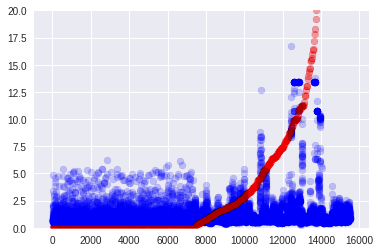

In [609]:
plt.scatter(pred_grid[:,0], pred_grid[:,1], c='b', alpha=0.2)
plt.scatter(test_grid[:,0], test_grid[:,1], c='r',alpha=0.01)
plt.ylim((0,20))
plt.show()

In [610]:
rec = np.transpose([np.sort(Results['abs_err'].values), 
        np.array(range(len(Results)))/len(Results)])

diff = np.abs(Results.y-np.mean(Results.y))

rec_mean = np.transpose([np.sort(diff),
        np.array(range(len(Results)))/len(Results) ])

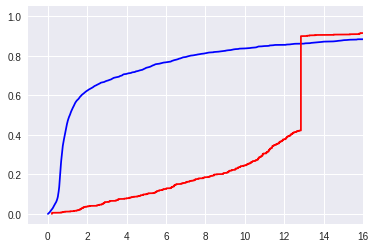

In [611]:
plt.plot(rec[:,0], rec[:,1], c='b')
plt.plot(rec_mean[:,0], rec_mean[:,1], c='r')
plt.xlim((-1,16))
plt.show()